In [78]:
from rdkit import Chem
from rdkit.Chem import rdchem
import pandas as pd

# Set display options and suppress all warnings
pd.set_option('display.max_columns', None)

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole  # Jupyter上で分子構造表示可能にする

import re
from collections import Counter

In [79]:
smiles_list = [
    "C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=CC=C3)C4=CC=CC(=C4)C5=CC=CC=C5",
    "C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=CC=C3)C4=CC=C(C=C4)C5=CC=CC6=CC=CC=C65",
    "C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=C(C=C3)C4=CC=CC=C4)C5=CC=C(C=C5)C6=CC=CC=C6",
    "C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=C(C=C3)C4=CC=CC=C4)C5=CC=C(C=C5)C6=CC(=CC=C6)N7C8C=CC=CC8C9=CC=CC=C97",
    "C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=C(C=C3)C#N)C4=CC=C(C=C4)C5=CC=CC=C5",
]

In [80]:
def normalize_dummy(smiles):
    """ダミー番号付き[*]を[*]に統一"""
    smiles = re.sub(r"\[\d*\*\]", "[*]", smiles)  # [数字*] を [*] に統一
    smiles = re.sub(r"\[\*:[0-9]+\]", "[*]", smiles) # [*:数字] を [*] に統一
    smiles = re.sub(r"(?<!\[)\*(?!\])", "[*]", smiles) # 単独の * を [*] に変換
    return smiles

def extract_triarylamine_substituents(smiles_list, mode="binary"):
    """
    トリアリールアミンのSMILESリストから置換基を抽出し、
    分子x置換基のDataFrameを返す。
    
    Args:
        smiles_list (list[str]): 入力SMILES
        mode (str): "binary" (0/1) or "count" (出現回数)
        
    Returns:
        df (pd.DataFrame)
        fl_map (dict): {FL-x: substituent smiles with [*]}
    """
    sub_to_fl = {}
    fl_counter = 1
    per_mol_subs = []
    mol_names = []

    # === 各分子ごとの処理 ===
    for i, smi in enumerate(smiles_list, start=1):
        mol_name = f"Mol-{i}"
        mol_names.append(mol_name)
        print(f"\n=== Processing {mol_name} ===\n{smi}")

        # 分子をSMILESから読み込む（sanitize=False で安全に）
        mol = Chem.MolFromSmiles(smi, sanitize=False)
        try:
            Chem.SanitizeMol(mol) # 化学的に整合性チェック
        except Exception as e:
            print("Sanitize warning:", e)

        # N原子を全て探索
        n_atoms = [a for a in mol.GetAtoms() if a.GetSymbol() == "N"]
        print(f"Total N atoms found: {len(n_atoms)}")
        
         # 候補: 非芳香族かつ結合数3のN原子（典型的なトリアリールアミン）
        candidate_ns = [a for a in n_atoms if (not a.GetIsAromatic()) and a.GetDegree() == 3]
        if not candidate_ns:
            print("No suitable amine N found. Skip.")
            per_mol_subs.append([])
            continue

        # 最初に見つかったN原子を採用（ジアミンは想定しない）
        target_N = candidate_ns[0]
        
        # Nとつながる結合をすべて取得
        bonds = [mol.GetBondBetweenAtoms(target_N.GetIdx(), nbr.GetIdx()).GetIdx()
                 for nbr in target_N.GetNeighbors()]
        print("Selected N:", target_N.GetIdx(), "bonds:", bonds)

        # Nとの結合を切断し、ダミー原子[*]を付与
        fragged = Chem.FragmentOnBonds(mol, bonds, addDummies=True)
        
        # 切断後のフラグメントを取得
        frags = Chem.GetMolFrags(fragged, asMols=True, sanitizeFrags=False)

        subs = [] # この分子の置換基を格納
        for frag in frags:
            atoms = frag.GetAtoms()
            has_dummy = any(at.GetAtomicNum() == 0 for at in atoms) # ダミー原子を含むか？
            if not has_dummy:
                continue # ダミーを含まないフラグメントは対象外

            # 「ダミーがNに直結している断片」は除外
            valid = True
            for at in atoms:
                if at.GetAtomicNum() == 0:  # ダミー原子
                    for nbr in at.GetNeighbors():
                        if nbr.GetSymbol() == "N": # ダミー直結がNならNG
                            valid = False
            if not valid:
                continue

            # フラグメントをSMILESに変換
            try:
                s = Chem.MolToSmiles(frag, isomericSmiles=True)
            except:
                # サニタイズを試してから再変換
                Chem.SanitizeMol(frag, catchErrors=True)
                s = Chem.MolToSmiles(frag, isomericSmiles=True)

            # ダミー表現を統一
            s = normalize_dummy(s)
            subs.append(s)

        print("Fragments:", subs)
        per_mol_subs.append(subs)

        # 新規の置換基にFLラベルを割り当てる
        for s in subs:
            if s not in sub_to_fl:
                sub_to_fl[s] = f"FL-{fl_counter}"
                fl_counter += 1

    # === DataFrame ===
    # FLラベル→置換基SMILES の辞書を作成
    fl_to_sub = {v: k for k, v in sub_to_fl.items()}
    # FL-x の番号順にソート
    sorted_fl = sorted(fl_to_sub.items(), key=lambda kv: int(kv[0].split("-")[1]))
    fl_cols = [kv[0] for kv in sorted_fl]
    fl_subs = [kv[1] for kv in sorted_fl]

    rows = []
    # 各分子の置換基を行ごとに埋める
    for subs in per_mol_subs:
        row = []
        for s in fl_subs:
            if mode == "binary":
                # binary モード: 含まれていれば 1、なければ 0
                row.append(1 if s in subs else 0)
            elif mode == "count":
                # count モード: 出現回数を数える
                row.append(subs.count(s))
            else:
                raise ValueError("mode must be 'binary' or 'count'")
        rows.append(row)

     # DataFrameにまとめる
    if fl_cols:
        df = pd.DataFrame(rows, columns=fl_cols)
        df.insert(0, "Molecule", mol_names)
    else:
        df = pd.DataFrame({"Molecule": mol_names})

    return df, {fl: fl_to_sub[fl] for fl in fl_cols}

In [81]:
# ==========================
# 実行例（あなたのSMILESリストをここに入れてください）
# ==========================

# binary
df_bin, fl_bin = extract_triarylamine_substituents(smiles_list, mode="binary")
print("\n=== Binary ===")
print(df_bin)
print(fl_bin)

# count
df_cnt, fl_cnt = extract_triarylamine_substituents(smiles_list, mode="count")
print("\n=== Count ===")
print(df_cnt)
print(fl_cnt)


=== Processing Mol-1 ===
C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=CC=C3)C4=CC=CC(=C4)C5=CC=CC=C5
Total N atoms found: 1
Selected N: 12 bonds: [11, 12, 18]
Fragments: ['[*]c1ccc(-c2ccccc2)cc1', '[*]c1ccccc1', '[*]c1cccc(-c2ccccc2)c1']

=== Processing Mol-2 ===
C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=CC=C3)C4=CC=C(C=C4)C5=CC=CC6=CC=CC=C65
Total N atoms found: 1
Selected N: 12 bonds: [11, 12, 18]
Fragments: ['[*]c1ccc(-c2ccccc2)cc1', '[*]c1ccccc1', '[*]c1ccc(-c2cccc3ccccc23)cc1']

=== Processing Mol-3 ===
C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=C(C=C3)C4=CC=CC=C4)C5=CC=C(C=C5)C6=CC=CC=C6
Total N atoms found: 1
Selected N: 12 bonds: [11, 12, 24]
Fragments: ['[*]c1ccc(-c2ccccc2)cc1', '[*]c1ccc(-c2ccccc2)cc1', '[*]c1ccc(-c2ccccc2)cc1']

=== Processing Mol-4 ===
C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=C(C=C3)C4=CC=CC=C4)C5=CC=C(C=C5)C6=CC(=CC=C6)N7C8C=CC=CC8C9=CC=CC=C97
Total N atoms found: 2
Selected N: 12 bonds: [11, 12, 24]
Fragments: ['[*]c1ccc(-c2ccccc2)cc1', '[*]c1ccc(-c2ccccc2)cc1', '[*]c1ccc(-c2cccc(N3c4cccc

In [82]:
pd.DataFrame(fl_cnt.items(), columns=["FL label", "Substituent SMILES with [*]"])

,FL label,Substituent SMILES with [*]
0,FL-1,[*]c1ccc(-c2ccccc2)cc1
1,FL-2,[*]c1ccccc1
2,FL-3,[*]c1cccc(-c2ccccc2)c1
3,FL-4,[*]c1ccc(-c2cccc3ccccc23)cc1
4,FL-5,[*]c1ccc(-c2cccc(N3c4ccccc4C4C=CC=CC43)c2)cc1
5,FL-6,[*]c1ccc(C#N)cc1


In [83]:
fl_bin

{'FL-1': '[*]c1ccc(-c2ccccc2)cc1',
 'FL-2': '[*]c1ccccc1',
 'FL-3': '[*]c1cccc(-c2ccccc2)c1',
 'FL-4': '[*]c1ccc(-c2cccc3ccccc23)cc1',
 'FL-5': '[*]c1ccc(-c2cccc(N3c4ccccc4C4C=CC=CC43)c2)cc1',
 'FL-6': '[*]c1ccc(C#N)cc1'}

In [84]:
df_bin

,Molecule,FL-1,FL-2,FL-3,FL-4,FL-5,FL-6
0,Mol-1,1,1,1,0,0,0
1,Mol-2,1,1,0,1,0,0
2,Mol-3,1,0,0,0,0,0
3,Mol-4,1,0,0,0,1,0
4,Mol-5,1,0,0,0,0,1


In [85]:
df_cnt

,Molecule,FL-1,FL-2,FL-3,FL-4,FL-5,FL-6
0,Mol-1,1,1,1,0,0,0
1,Mol-2,1,1,0,1,0,0
2,Mol-3,3,0,0,0,0,0
3,Mol-4,2,0,0,0,1,0
4,Mol-5,2,0,0,0,0,1


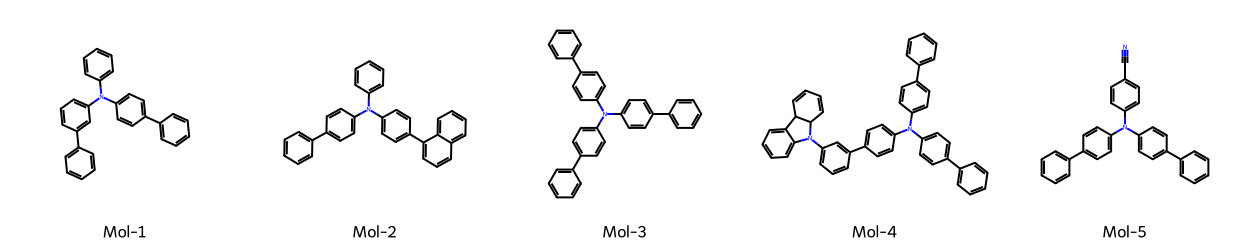

In [86]:
# 元分子
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
img_mols = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250,250),
                                legends=[f"Mol-{i+1}" for i in range(len(mols))])
display(img_mols)

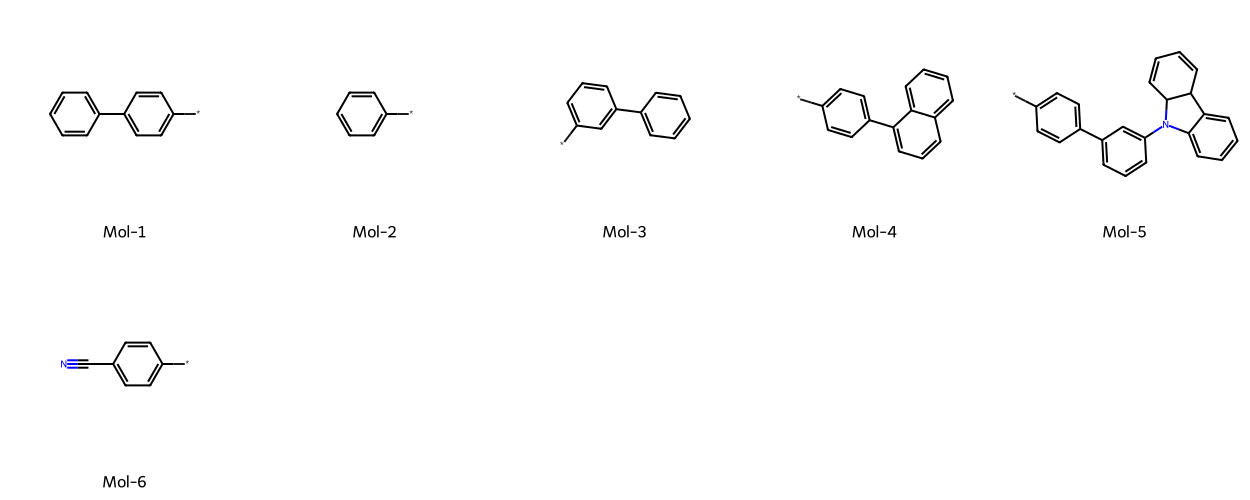

In [87]:
mols = [Chem.MolFromSmiles(smi) for smi in fl_cnt.values()]
img_mols = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250,250),
                                legends=[f"Mol-{i+1}" for i in range(len(mols))])
display(img_mols)